# IA de prédiction de l'impact environnemental
Cette IA à pour but de prédir l'impact sur le changement climatique (CO2 équivalent) d'un produit alimentaire.


# Exemple de base

## Import

In [200]:
# Manipulation de données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - modèles
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Prétraitement
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Évaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import LabelEncoder

## Data d'entraînement
Les données pour entraîner le modèle proviennent de l'ADEME et sont disponibles [à cette adresse](https://www.data.gouv.fr/datasets/agribalyse-3-1-synthese/).

In [201]:
df = pd.read_csv("agribalyse_data.csv", sep=",")
# Aperçu
df.head()

,Code AGB,Code CIQUAL,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,LCI Name,code saison,code avion,Livraison,Approche emballage,...,Eutrophisation marine,Eutrophisation terrestre,Écotoxicité pour écosystèmes aquatiques d'eau douce,Utilisation du sol,Épuisement des ressources eau,Épuisement des ressources énergétiques,Épuisement des ressources minéraux,Changement climatique - émissions biogéniques,Changement climatique - émissions fossiles,Changement climatique - émissions liées au changement d'affectation des sols
0,11172,11172.0,aides culinaires et ingrédients divers,aides culinaires,"Court-bouillon pour poissons, déshydraté","Aromatic stock cube, for fish, dehydrated",2.0,0.0,Ambiant (long),PACK PROXY,...,0.02680,0.1370,70.2,106.0,3.380,700.0,0.000051,0.1040,7.460,0.02120
1,25525,25525.0,aides culinaires et ingrédients divers,aides culinaires,"Pizza, sauce garniture pour",Topping sauce for pizza,2.0,0.0,Ambiant (long),PACK PROXY,...,0.00416,0.0303,11.0,67.7,2.470,24.4,0.000006,0.0336,1.020,-0.10800
2,11214,11214.0,aides culinaires et ingrédients divers,aides culinaires,"Préparation culinaire à base de soja, type ""cr...","Soy ""cream"" preparation",2.0,0.0,Ambiant (long),PACK PROXY,...,0.00723,0.0244,30.8,116.0,0.422,22.4,0.000004,0.0252,0.965,0.18400
3,11084,11084.0,aides culinaires et ingrédients divers,algues,"Agar (algue), cru","Seaweed, agar, raw",2.0,0.0,Ambiant (long),PACK PROXY,...,0.01500,0.1440,57.9,26.7,4.830,396.0,0.000079,0.0401,11.700,0.00655
4,20995,20995.0,aides culinaires et ingrédients divers,algues,"Ao-nori (Enteromorpha sp.), séchée ou déshydratée","Sea lettuce (Enteromorpha sp.), dried or dehyd...",2.0,0.0,Ambiant (long),PACK PROXY,...,0.01500,0.1440,57.9,26.7,4.830,396.0,0.000079,0.0401,11.700,0.00655


## Train Set
En machine learning, on divise les données en deux parties principales :
-Train Set (jeu d'entraînement)
-Test Set (jeu de test)

Cette séparation est essentielle pour évaluer la performance réelle du modèle.
Le Train Set est utilisé pour entraîner le modèle, c’est-à-dire lui faire apprendre les relations entre les variables d’entrée et la variable cible.
Le Test Set, lui, n’est jamais montré au modèle pendant l’entraînement. Il sert à simuler de nouvelles données jamais vues, comme dans un cas réel d’utilisation.
Cela permet de vérifier si le modèle généralise bien, c’est-à-dire s’il est capable de faire de bonnes prédictions sur des données inconnues et pas juste de “mémoriser” l’entraînement.

In [202]:
main_target = 'Changement climatique'

def setup(target):
    #Définir la variable cible
    y = df[target]

    #Supprimer la cible de X
    X = df.drop(target, axis=1)

    # Garder uniquement les lignes sans NaN dans y
    mask = y.notna()
    y = y.loc[mask]
    X = df.loc[mask].drop(target, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

setup(main_target)

## Pipeline de transformation
Les données non numériques ne peuvent pas être traitées directement par notre modèle, il faut donc les transformer. Plusieurs solutions existent, comme l'encodage par label (non adapté aux modèles linéaires) ou l'encodage one-hot, qui est préférable ici.
Il faut également décider comment gérer les données manquantes : supprimer les lignes concernées ou les remplacer par une valeur par défaut.

In [203]:
# Sélecteurs automatiques
numerical_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

# Pipelines
numerical_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),  # remplace NaN par moyenne
    StandardScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='unknown'),  # remplace NaN par 'unknown'
    OneHotEncoder(handle_unknown="ignore")
)

# Préprocesseur complet
preprocessor = make_column_transformer(
    (numerical_pipeline, numerical_features),
    (categorical_pipeline, categorical_features)
)

def regressor(model_type):
    model = Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', model_type)
    ])
    return model

## Fonction d'évaluation

In [204]:
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Afficher des métriques adaptées à la régression
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R2 score:", r2_score(y_test, y_pred))

    # Learning curve (attention scoring doit être adapté)
    N, train_score, val_score = learning_curve(
        model, X_train, y_train,
        cv=4, scoring='r2', train_sizes=np.linspace(0.1, 1, 10)
    )
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.show()

MSE: 0.004375897683299186
MAE: 0.03361960503444749
R2 score: 0.9999466064190032


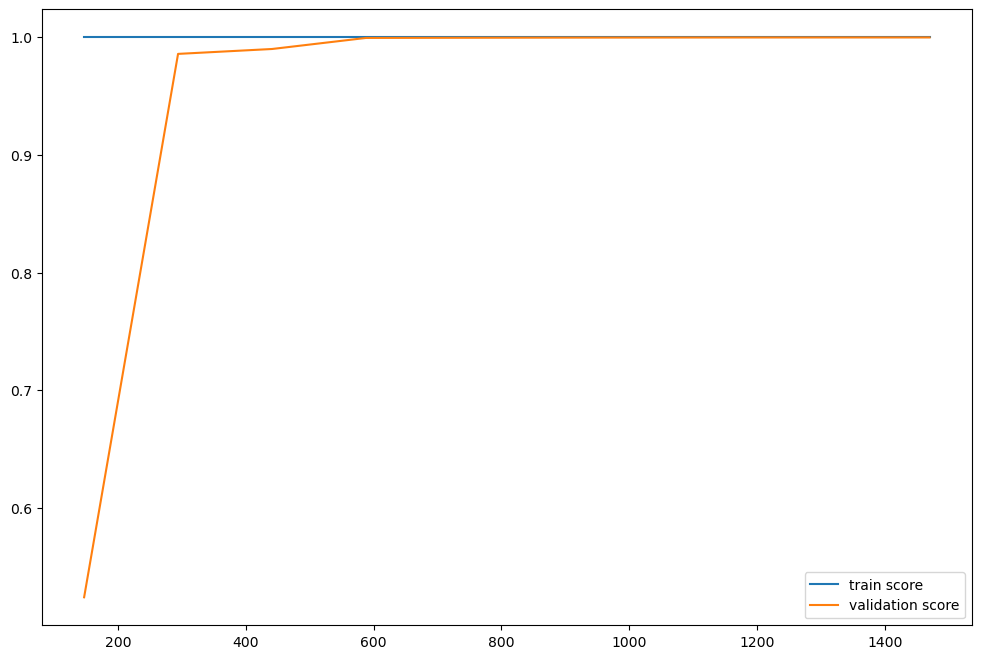

In [205]:
model = regressor(LinearRegression())
evaluation(model)

## Corrélation
La corrélation est une mesure statistique qui indique dans quelle mesure deux variables sont liées entre elles. Elle varie entre :
+1 : corrélation positive parfaite → quand une variable augmente, l'autre aussi.
0 : aucune corrélation → les deux variables n'ont pas de lien linéaire direct.
-1 : corrélation négative parfaite → quand une variable augmente, l'autre diminue.

In [206]:
def cor_eval(display=True):
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    num_corr = df[numerical_cols].corr(method='pearson')[main_target].drop(main_target)

    if display:
        print("Corrélations Pearson avec " + main_target + " :\n")
        print(num_corr.sort_values(ascending=False))
        return

    return num_corr.to_dict()

cor_eval()

Corrélations Pearson avec Changement climatique :

Score unique EF                                                                 0.953969
Eutrophisation terrestre                                                        0.935170
Acidification terrestre et eaux douces                                          0.930355
Particules fines                                                                0.925290
Changement climatique - émissions biogéniques                                   0.906216
Effets toxicologiques sur la santé humaine : substances cancérogènes            0.893707
Utilisation du sol                                                              0.865662
Effets toxicologiques sur la santé humaine : substances non-cancérogènes        0.828495
Changement climatique - émissions fossiles                                      0.800442
Écotoxicité pour écosystèmes aquatiques d'eau douce                             0.667394
Eutrophisation marine                                      

## Feature Engineering
Après avoir examiné les corrélations entre les différentes variables et notre variable cible, nous sommes en mesure d’identifier celles qui ont un impact significatif sur le modèle. En conservant les variables les plus pertinentes et en supprimant celles qui présentent une corrélation faible ou négligeable, nous améliorons la qualité des données utilisées. Ce travail de sélection, de transformation ou de création de nouvelles variables à partir des données existantes s’appelle le Feature Engineering.

In [199]:
def drop_columns(threshold, upper=False):
    # Récupérer toutes les corrélations/scores (num + catégoriel)
    scores = cor_eval(display=False)

    if upper:
        # Supprimer colonnes avec score >= threshold
        cols_to_drop = [col for col, score in scores.items() if score >= threshold]
    else:
        # Supprimer colonnes avec score < threshold
        cols_to_drop = [col for col, score in scores.items() if score < threshold]

    # Supprimer colonnes dans df (ignore les erreurs si colonne absente)
    global df  # si tu veux modifier la variable globale df
    df = df.drop(columns=cols_to_drop, errors='ignore')

    print(f"Colonnes supprimées ({'>= ' if upper else '< '} {threshold}): {cols_to_drop}")

# Exemple d'utilisation :
drop_columns(0.20)  # supprime colonnes avec score < 0.20

Colonnes supprimées (<  0.2): ['Code CIQUAL', 'code saison', 'code avion', 'DQR', "Appauvrissement de la couche d'ozone", 'Épuisement des ressources eau']


# Cas plus compliqué